# Markowitz Python

In [4]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [6]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)

In [7]:
#lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
#lista_acoes = [acao + ".SA" for acao in lista_acoes]
lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, inicio, final)['Adj Close']
precos

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOGL,NKE
Date,,,,
2015-01-02,24.565699,15.426000,26.477501,43.512913
2015-01-05,23.873644,15.109500,25.973000,42.812344
2015-01-06,23.875891,14.764500,25.332001,42.560520
2015-01-07,24.210680,14.921000,25.257500,43.439651
2015-01-08,25.140909,15.023000,25.345501,44.442432
...,...,...,...,...
2022-12-23,131.658981,85.250000,89.230003,115.919472
2022-12-27,129.831772,83.040001,87.389999,117.225746
2022-12-28,125.847855,81.820000,86.019997,114.653084


In [8]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() #retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov() 

media_retornos

AAPL     0.000827
AMZN     0.000842
GOOGL    0.000598
NKE      0.000490
dtype: float64

In [9]:
matriz_cov

,AAPL,AMZN,GOOGL,NKE
AAPL,0.000356,0.000232,0.000216,0.000172
AMZN,0.000232,0.000436,0.000247,0.000164
GOOGL,0.000216,0.000247,0.000316,0.000165
NKE,0.000172,0.000164,0.000165,0.000348


In [13]:
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos) #só pode ter 100% 
    tabela_pesos[k, :] = pesos
    
    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

In [15]:
vetor_sharpe

array([0.72043578, 0.67523935, 0.71720442, ..., 0.70842075, 0.64832649,
       0.70793513])

In [16]:
indice_do_sharpe_maximo = vetor_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.59022473, 0.35627142, 0.00380913, 0.04969472])

In [17]:
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

tabela_retornos_esperados_arit

array([0.20866625, 0.18191764, 0.19530612, ..., 0.19472704, 0.17106864,
       0.19172902])

In [19]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), 
                                         tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) 

limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    #vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, 
                      constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

In [25]:
result

     fun: 0.2959032919516592
     jac: array([0.22725052, 0.32270736, 0.20317372, 0.14131894])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([2.80797794e-01, 7.19202206e-01, 8.67361738e-17, 0.00000000e+00])

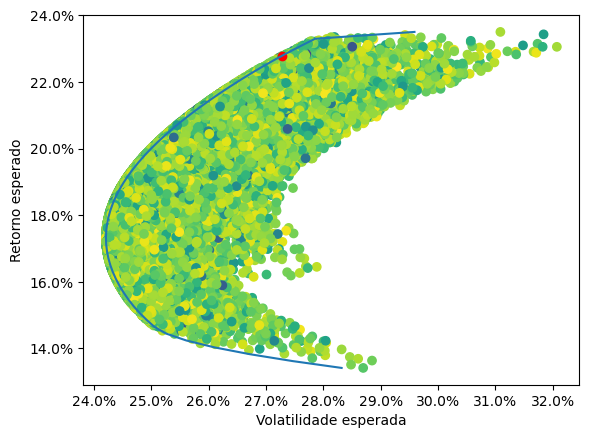

In [24]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[indice_do_sharpe_maximo], 
            tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()